<a href="https://colab.research.google.com/github/Kala-Ayush/Data-Analysis/blob/main/Gutenberg_Book_Classifier_(NLP)_Ayush_Kala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instructions

In this exercise, we will practice Natural Language Processing by performing classification on book texts.

We will train a model on a corpus consisting of a handful of books. Then for a given passage of text, we will use the model to predict which book that text is most likely to come from.

Many steps have been done for you, but there are ten "Tasks" you will need to complete along the way.
  



## Setup

In [ ]:
%%capture
!pip install gutenbergpy

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Loading


Here is a helper function to load book text from [Project Gutenberg](https://gutenberg.org/browse/scores/top):

In [ ]:
from gutenbergpy.textget import get_text_by_id, strip_headers
import re


def get_book(book_id=2701):
    """Fetches the text of a book given its gutenberg identifier.

        For a list of books and identifiers, see: https://gutenberg.org/browse/scores/top.

        Performs light touch preprocessing, just in hopes of getting some readable text.

        Returns the text as a string.
    """
    print("FETCHING BOOK:", book_id)
    raw_book = get_text_by_id(book_id) # with headers
    clean_book = strip_headers(raw_book) # without headers
    # we are dealing with bytes at this point

    # remove weird unicode characters:
    clean_book = clean_book.decode("utf-8").encode("ascii", "ignore")

    text = str(clean_book)
    text = text.replace("\\n", " ").replace("\\", "")

    # remove extra whitespace:
    text = re.sub(r'\s+', ' ', text)

    return text.strip()


book = get_book(64317)
print(type(book), len(book))
book[0:1000]
#book[-1000:]

FETCHING BOOK: 64317
<class 'str'> 263367


"b' ttt The Great Gatsby tttt by ttt F. Scott Fitzgerald Table of Contents I II III IV V VI VII VIII IX Once again to Zelda Then wear the gold hat, if that will move her; If you can bounce high, bounce for her too, Till she cry Lover, gold-hatted, high-bouncing lover, I must have you! Thomas Parke dInvilliers I In my younger and more vulnerable years my father gave me some advice that Ive been turning over in my mind ever since. Whenever you feel like criticizing anyone, he told me, just remember that all the people in this world havent had the advantages that youve had. He didnt say any more, but weve always been unusually communicative in a reserved way, and I understood that he meant a great deal more than that. In consequence, Im inclined to reserve all judgements, a habit that has opened up many curious natures to me and also made me the victim of not a few veteran bores. The abnormal mind is quick to detect and attach itself to this quality when it appears in a normal person, and

### Book Selection [Task 0]

Choose your own set of three books available from Project Gutenberg, and note the identifiers.

Here is a curated list of examples:

  + 16: Peter Pan
  + 55: Wizard of Oz
  + 1062: Edgar Allen Poe Collection
  + 1342: Pride and Prejudice
  + 1437: Little Women
  + 1513: Romeo and Juliet
  + 1727: The Odyssey
  + 64317: Great Gatsby
  
  + 67098: Winnie the Pooh

Or reference the complete list here:
https://gutenberg.org/browse/scores/top


Update the `book_records` variable below, as desired, to include your chosen book names and identifiers:

In [ ]:
from pandas import DataFrame, Series

book_records = [
    {"book_id": 16, "book_name": "PETER_PAN"},
    {"book_id": 55, "book_name": "WIZARD_OZ"},
    {"book_id": 67098, "book_name": "WINNIE_POOH"},
    # choose your own books of interest! three to five should be fine
]
books_df = DataFrame(book_records)
books_df.index = books_df["book_id"]
books_df

,book_id,book_name
book_id,,
16,16,PETER_PAN
55,55,WIZARD_OZ
67098,67098,WINNIE_POOH


Fetching text and storing in a new column for each book:

In [ ]:
books_df["book_text"] = books_df["book_id"].apply(lambda book_id: get_book(book_id))
books_df["book_length_chars"] = books_df["book_text"].apply(lambda text: len(text))
books_df

FETCHING BOOK: 16
FETCHING BOOK: 55
FETCHING BOOK: 67098


,book_id,book_name,book_text,book_length_chars
book_id,,,,
16,16,PETER_PAN,b' Peter Pan [PETER AND WENDY] by J. M. Barrie...,250176
55,55,WIZARD_OZ,b' [Illustration] The Wonderful Wizard of Oz b...,204087
67098,67098,WINNIE_POOH,b' WINNIE-THE-POOH _BY A. A. MILNE_ _JUVENILES...,124195


## Token Analysis (Side Quest)

### Tokenizer Function [Task 1]



Consider two example tokenizer functions provided for you.

Optionally implement your own tokenization strategy in your own tokenizer function (i.e. `my_tokenizer`).

Inspect the most frequent tokens produced by each of the three tokenization functions, and see which strategy you like best.

Iterate, revise, and update your custom tokenization function until you are satisfied with the results.


1) Simple Preprocessor ([source code](https://tedboy.github.io/nlps/_modules/gensim/utils.html#simple_preprocess
)):

In [ ]:
# https://tedboy.github.io/nlps/_modules/gensim/utils.html#simple_preprocess
from gensim.utils import simple_preprocess

books_df["simple_tokens"] = books_df["book_text"].apply(simple_preprocess)
books_df

,book_id,book_name,book_text,book_length_chars,simple_tokens
book_id,,,,,
16,16,PETER_PAN,b' Peter Pan [PETER AND WENDY] by J. M. Barrie...,250176,"[peter, pan, peter, and, wendy, by, barrie, ja..."
55,55,WIZARD_OZ,b' [Illustration] The Wonderful Wizard of Oz b...,204087,"[illustration, the, wonderful, wizard, of, oz,..."
67098,67098,WINNIE_POOH,b' WINNIE-THE-POOH _BY A. A. MILNE_ _JUVENILES...,124195,"[winnie, the, pooh, milne_, when, we, were, ve..."


2) Spacy tokenizer, with stopword removal and lemmatization:

In [ ]:
import re
#import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


def spacy_tokenize(text, stop_words=ENGLISH_STOP_WORDS):
    text = text.lower()
    #text = re.sub(r'\d+', '', text) # remove numbers
    text = text.replace('_', '')

    # Remove punctuation
    #text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization with spaCy
    doc = nlp(text)
    #tokens = [token.text for token in doc if (token not in stop_words and !token.is_stop)]
    lemmas = [token.lemma_ for token in doc if
        (token not in stop_words)
        and not token.is_stop
        and not token.is_punct
        and len(token.text) > 2 and len(token.text) < 15 # this is what the simple preprocessor does
        and token.text.strip() != ""
    ]

    return lemmas


books_df["spacy_tokens"] = books_df["book_text"].apply(spacy_tokenize)
books_df

,book_id,book_name,book_text,book_length_chars,simple_tokens,spacy_tokens
book_id,,,,,,
16,16,PETER_PAN,b' Peter Pan [PETER AND WENDY] by J. M. Barrie...,250176,"[peter, pan, peter, and, wendy, by, barrie, ja...","[peter, pan, peter, wendy, barrie, james, matt..."
55,55,WIZARD_OZ,b' [Illustration] The Wonderful Wizard of Oz b...,204087,"[illustration, the, wonderful, wizard, of, oz,...","[illustration, wonderful, wizard, frank, baum,..."
67098,67098,WINNIE_POOH,b' WINNIE-THE-POOH _BY A. A. MILNE_ _JUVENILES...,124195,"[winnie, the, pooh, milne_, when, we, were, ve...","[winnie, pooh, milne, juvenile, young, good, b..."


3) Your own custom tokenizer:

In [ ]:

def my_tokenizer(text):

    tokens = [] # TODO: explore your own tokenization strategy!

    return tokens


books_df["my_tokens"] = books_df["book_text"].apply(my_tokenizer)
books_df

,book_id,book_name,book_text,book_length_chars,simple_tokens,spacy_tokens,my_tokens
book_id,,,,,,,
16,16,PETER_PAN,b' Peter Pan [PETER AND WENDY] by J. M. Barrie...,250176,"[peter, pan, peter, and, wendy, by, barrie, ja...","[peter, pan, peter, wendy, barrie, james, matt...",[]
55,55,WIZARD_OZ,b' [Illustration] The Wonderful Wizard of Oz b...,204087,"[illustration, the, wonderful, wizard, of, oz,...","[illustration, wonderful, wizard, frank, baum,...",[]
67098,67098,WINNIE_POOH,b' WINNIE-THE-POOH _BY A. A. MILNE_ _JUVENILES...,124195,"[winnie, the, pooh, milne_, when, we, were, ve...","[winnie, pooh, milne, juvenile, young, good, b...",[]


### Top Tokens

Below we are displaying the top tokens for each book. Choose your preferred tokenization strategy:

In [ ]:
from collections import Counter
from pprint import pprint

for i, row in books_df.iterrows():
    print("-----------------------")
    print(row["book_name"])

    # CHOOSE YOUR PREFERRED TOKENS:
    #tokens = row["simple_tokens"]
    tokens = row["spacy_tokens"]
    #tokens = row["my_tokens"]

    counter = Counter(tokens)
    pprint(counter.most_common(15))


-----------------------
PETER_PAN
[('say', 389),
 ('peter', 381),
 ('wendy', 332),
 ('know', 188),
 ('cry', 183),
 ('come', 173),
 ('hook', 172),
 ('boy', 147),
 ('think', 147),
 ('time', 137),
 ('look', 128),
 ('john', 127),
 ('darling', 120),
 ('mother', 119),
 ('like', 114)]
-----------------------
WIZARD_OZ
[('dorothy', 365),
 ('say', 340),
 ('scarecrow', 227),
 ('lion', 183),
 ('woodman', 179),
 ('come', 176),
 ('great', 150),
 ('tin', 140),
 ('little', 139),
 ('ask', 139),
 ('witch', 138),
 ('good', 114),
 ('head', 107),
 ('green', 104),
 ('look', 100)]
-----------------------
WINNIE_POOH
[('say', 594),
 ('pooh', 438),
 ('piglet', 226),
 ('christopher', 165),
 ('robin', 165),
 ('think', 156),
 ('eeyore', 121),
 ('go', 117),
 ('rabbit', 113),
 ('look', 104),
 ('come', 100),
 ('kanga', 85),
 ('little', 82),
 ('owl', 81),
 ('like', 80)]


### Word Clouds [Task 2]

Using your preferred tokenization strategy...

Display a word cloud or tree map of top tokens for each book:

In [ ]:
pip install wordcloud


-----------------------
Word Cloud for PETER_PAN


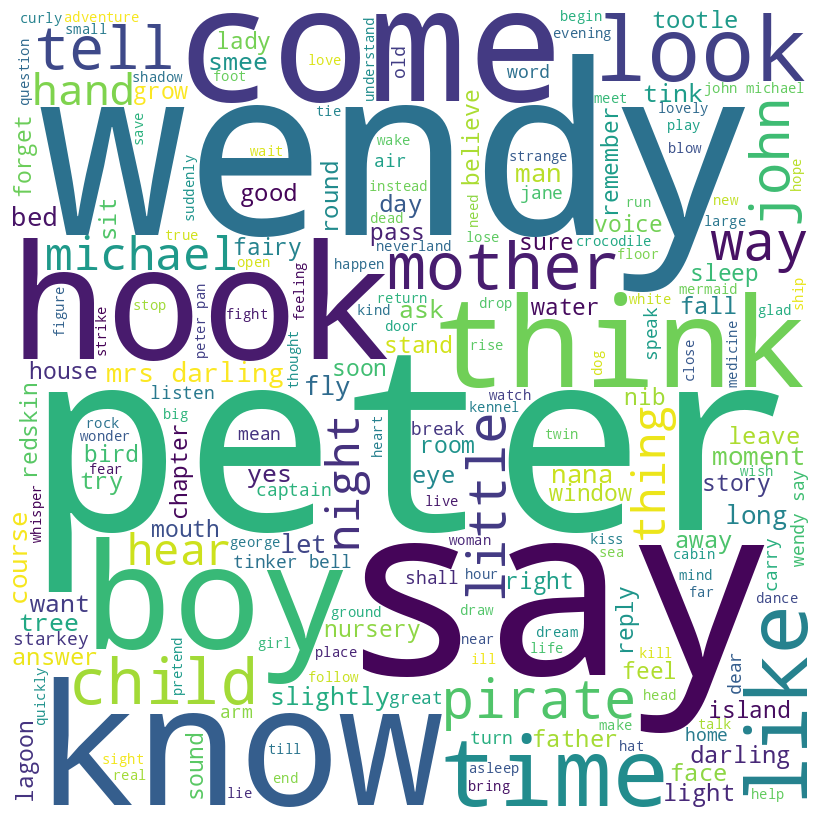

-----------------------
Word Cloud for WIZARD_OZ


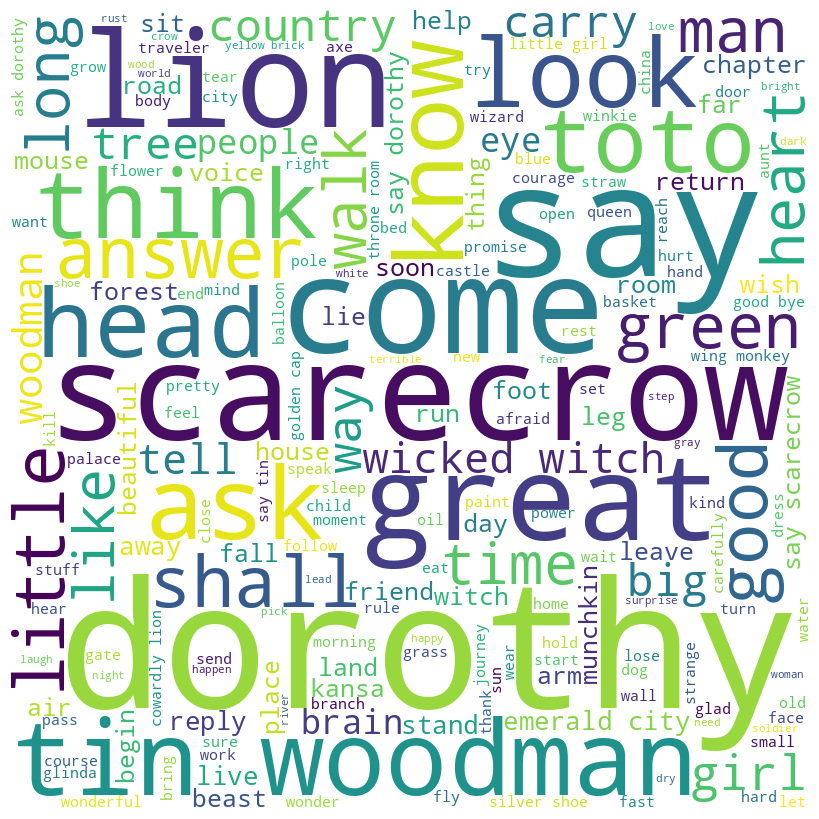

-----------------------
Word Cloud for WINNIE_POOH


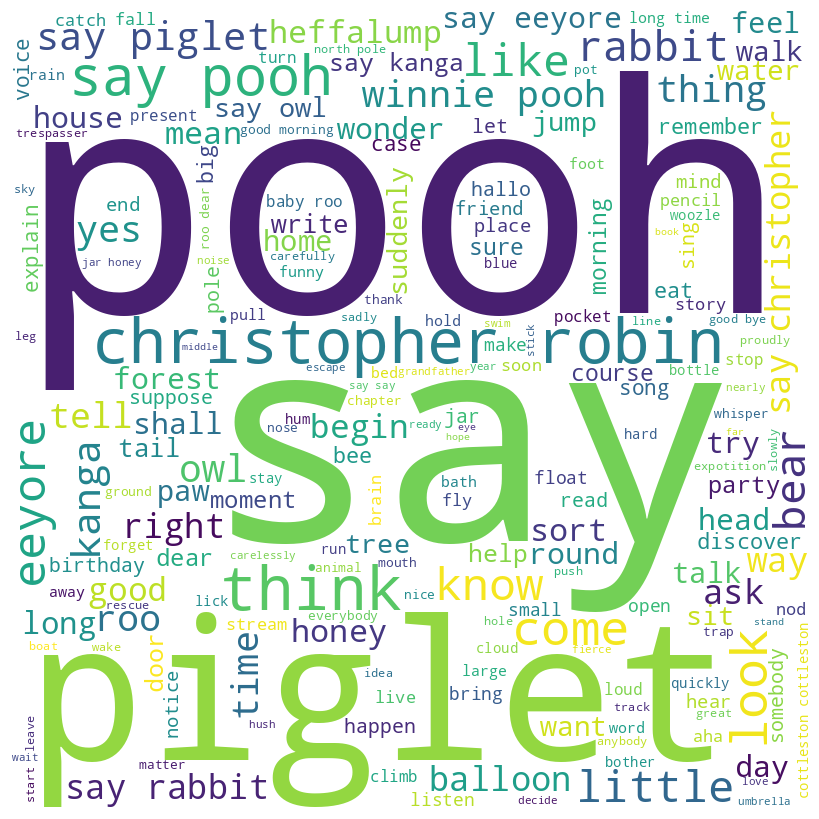

In [ ]:
#Used a combination of professors code and ChatGPT in some places
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for i, row in books_df.iterrows():
    print("-----------------------")
    print(f"Word Cloud for {row['book_name']}")

    text = ' '.join(row['spacy_tokens'])

    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = ENGLISH_STOP_WORDS,
                min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()


## Corpus of Sentences

So far in our books dataframe, we only have three rows. We have a row per book, with each row containing the entire book text.

This may not work the best for our usual machine learning approach. For example, how would we train test split? We need to have certain parts of each book to use in our training set, and other parts from each book in the test set.

So, let's split each book into sentences, so our new corpus will have a row per sentence, with a label of which book it came from. We can use this sentence-based corpus moving forward.

In [ ]:
records = []

for index, row in books_df.iterrows():
    book_name = row["book_name"]
    clean_text = row["book_text"]

    sentences = nltk.sent_tokenize(clean_text)
    for i, sentence in enumerate(sentences):
        records.append({"book_name": book_name, "sentence_id": i, "sentence": sentence})

sentences_df = DataFrame(records)
sentences_df

,book_name,sentence_id,sentence
0,PETER_PAN,0,b' Peter Pan [PETER AND WENDY] by J. M. Barrie...
1,PETER_PAN,1,Note that while a copyright was initially clai...
2,PETER_PAN,2,"This text, which matches the 1911 original pub..."
3,PETER_PAN,3,Contents Chapter I. PETER BREAKS THROUGH Chapt...
4,PETER_PAN,4,THE SHADOW Chapter III.
...,...,...,...
7573,WINNIE_POOH,1986,"""I might,"" I said."
7574,WINNIE_POOH,1987,"""Was Pooh's pencil case any better than mine?"""
7575,WINNIE_POOH,1988,"""It was just the same,"" I said."
7576,WINNIE_POOH,1989,He nodded and went out ... and in a moment I h...


In [ ]:
sentences_df["book_name"].value_counts()

PETER_PAN      3340
WIZARD_OZ      2247
WINNIE_POOH    1991
Name: book_name, dtype: int64

## Part I - Benchmark Model

### X/Y Split [Task 3]

Split the corpus of sentences (i.e. the `sentences_df`) into x and y datasets. Choose the book name as the target, and the column of sentence text as the features.

In [ ]:
from sklearn.model_selection import train_test_split

X = sentences_df['sentence']
y = sentences_df['book_name']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58)

### Vectorization [Task 4]

Use TF-IDF vectorizor from sklearn to transform the corpus of sentences (x) into a document term matrix.

When storing the TF-IDF object instance in a variable, specifically name it `vectorizer` (so provided code in Task 9 code will work).


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

(X_train_tfidf.shape, X_test_tfidf.shape)


((6062, 6102), (1516, 6102))

### Train Test Split [Task 5]

Split the data into test and train sets, using the train test split function from sklearn. Remember to use a random seed for reproducibility.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58)



### Model Training [Task 6]

Train a Logistic Regression model from sklearn on the training data.

When storing the Logistic Regression object instance in a variable, specifically name it `model` (so provided code in Task 9 code will work).

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=58)
model.fit(X_train_tfidf, y_train)


LogisticRegression(random_state=58)

### Model Explainability [Task 7]

Inspect the model's learned weights (i.e. the coefficients).

For each book, what terms are most predictive / related to that book? For each book, print the names and weights of the "top ten" features (i.e. those having the hightest positive weights).

In [ ]:
coefficients = model.coef_
feature_names = vectorizer.get_feature_names_out()

top_features_per_book = {}

for i, class_label in enumerate(model.classes_):
    top_indices = coefficients[i].argsort()[-10:][::-1]
    top_features = [(feature_names[j], coefficients[i][j]) for j in top_indices]
    top_features_per_book[class_label] = top_features

for book, features in top_features_per_book.items():
    print(f"Top ten features for {book}:")
    for feature, weight in features:
        print(f"  {feature}: {weight:.4f}")
    print("\n")

Top ten features for PETER_PAN:
  peter: 5.0471
  wendy: 4.5476
  hook: 3.3219
  john: 2.9657
  darling: 2.8092
  michael: 2.5302
  mother: 2.5103
  boys: 2.4263
  mrs: 2.1614
  children: 2.1367


Top ten features for WINNIE_POOH:
  pooh: 5.1593
  piglet: 4.2295
  eeyore: 3.0100
  roo: 2.8529
  rabbit: 2.8203
  kanga: 2.7449
  robin: 2.5974
  christopher: 2.5626
  owl: 2.4584
  bear: 2.3566


Top ten features for WIZARD_OZ:
  dorothy: 5.2530
  scarecrow: 3.8802
  oz: 3.5928
  the: 3.4716
  lion: 3.4600
  woodman: 2.7224
  toto: 2.6720
  green: 2.4786
  witch: 2.3815
  tin: 2.2177




### Model Evaluation [Task 8]

A) Use the trained model to make predictions on the test set.

B) Use the predictions to evaluate the model. Specifically display a classification report.

C) Also compute the ROC AUC score, using the predicted probabilities.

D) Finally, display a confusion matrix, as a heatmap.

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test_tfidf)





In [ ]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

   PETER_PAN       0.86      0.94      0.90       701
 WINNIE_POOH       0.90      0.83      0.86       356
   WIZARD_OZ       0.91      0.83      0.87       459

    accuracy                           0.88      1516
   macro avg       0.89      0.87      0.88      1516
weighted avg       0.88      0.88      0.88      1516



In [ ]:
y_prob = model.predict_proba(X_test_tfidf)

from sklearn.preprocessing import label_binarize
y_test_binarized = label_binarize(y_test, classes=model.classes_)
roc_auc = roc_auc_score(y_test_binarized, y_prob, multi_class='ovr')

print(f"ROC AUC Score: {roc_auc:.4f}\n")



ROC AUC Score: 0.9717



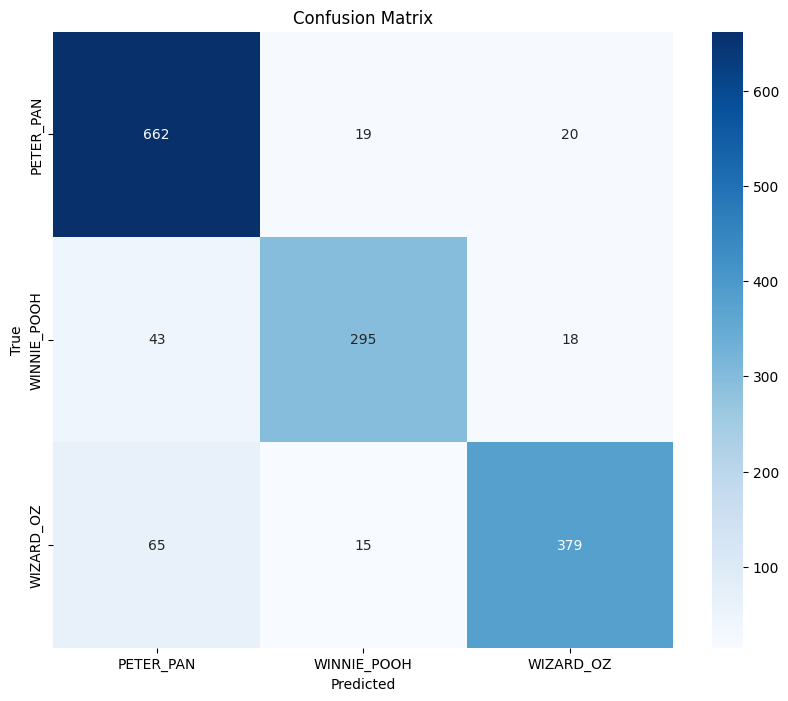

In [ ]:
confuse = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confuse, annot=True, fmt='g', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Inference [Task 9]

Create your own example sentences that might use similar language as each of the books you have chosen.

Use the trained model to predict which book most closely resembles the language used in each of the new sentences.

See example below, but use your own sentences corresponding with the books you have chosen. Feel free to add more sentences and revise as desired

In [ ]:
new_sentences = [
    "Lions and tigers and bears oh my. Wicked Witch.",
    "Oh bother. Piglet. I love honey. Honey pot. Christopher Robin.",
    "Tinkerbell flew over Captain Hook and all the lost boys in neverland cheered.",
]
new_sentences_x = vectorizer.transform(new_sentences)
predictions = model.predict(new_sentences_x)
print("Predictions:", predictions)

Predictions: ['WIZARD_OZ' 'WINNIE_POOH' 'PETER_PAN']


In [ ]:
from pandas import Series

preds_df = Series(predictions, index=new_sentences)
preds_df

Lions and tigers and bears oh my. Wicked Witch.                                    WIZARD_OZ
Oh bother. Piglet. I love honey. Honey pot. Christopher Robin.                   WINNIE_POOH
Tinkerbell flew over Captain Hook and all the lost boys in neverland cheered.      PETER_PAN
dtype: object

## Part II - Best Model [Task 10]


Use a grid search from sklearn, in conjunction with a pipeline from sklearn, to find the combination of vectorizer and model parameters that yield the best classification results.

Explore at least two different classifier models (e.g. Logistic Regression and Naive Bayes), performing a separate grid search for each.

For each:

  + Setup a pipeline containing a TF-IDF vectorizer, as well as the chosen model.

  + For the TF-IDF parameter grid, explore using different vectorization parameters, including different tokenization functions and stopword removal strategies, etc.

  + For the model's parameter grid, because different models use different parameters, your parameter grid will need to reflect the parameters of the chosen model.

  + Setup a grid search using the pipeline and the parameter grid. Use five fold cross validation. And choose "auc_roc_ovr" as the scoring metric to optimize on.

  + After training the grid search, print the best parameters that it found. Also conduct a formal evaluation including classification report and confusion matrix (similar to Task 8).


Finally, summarize your results in a text cell at the bottom, and answer the questions posed there.


### Best Logistic Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters - Logistic Regression:
{'logreg__C': 10, 'logreg__penalty': 'l2', 'tfidf__max_features': 1500, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}
Classification Report - Logistic Regression:

              precision    recall  f1-score   support

   PETER_PAN       0.95      0.96      0.96       701
 WINNIE_POOH       0.93      0.95      0.94       356
   WIZARD_OZ       0.97      0.95      0.96       459

    accuracy                           0.95      1516
   macro avg       0.95      0.95      0.95      1516
weighted avg       0.95      0.95      0.95      1516



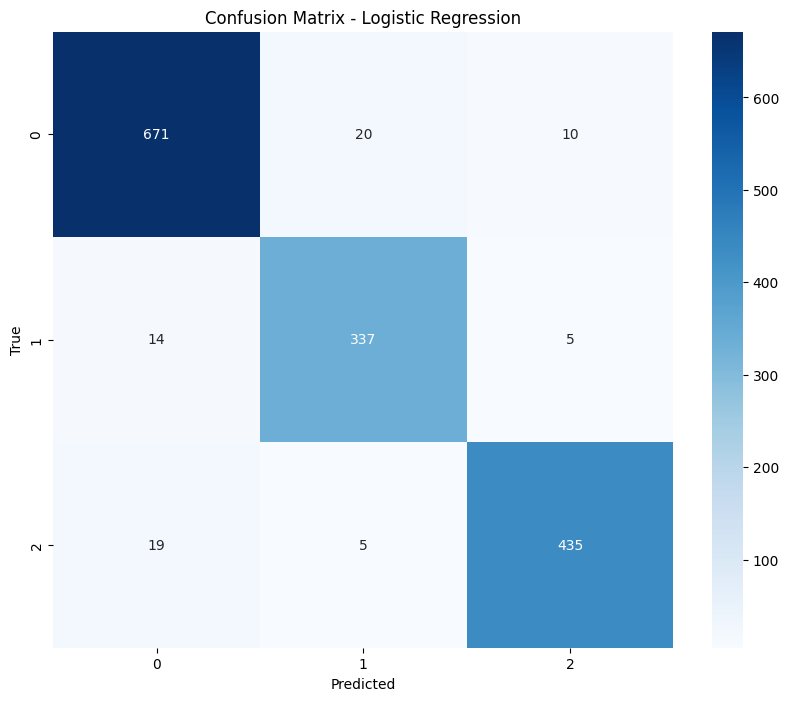

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

# took help from Abhijit for parameters
tfidf_param_grid = {
    'tfidf__max_features': [500, 1000, 1500],
    'tfidf__stop_words': [None, 'english'],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
}

logreg_param_grid = {
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2'],
}

param_grid_lr = {**tfidf_param_grid, **logreg_param_grid}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='roc_auc_ovr')
grid_search_lr.fit(X, y)

print("Best parameters - Logistic Regression:")
print(grid_search_lr.best_params_)

y_pred_lr = grid_search_lr.predict(X_test)
print("Classification Report - Logistic Regression:\n")
print(classification_report(y_test, y_pred_lr))
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

y_pred_proba_lr = grid_search_lr.predict_proba(X_test)

roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr, multi_class='ovr')
print("ROC AUC Score - Logistic Regression:", roc_auc_lr)


ROC AUC Score - Logistic Regression: 0.9951268604229334


### Best Naive Bayes

http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

Best parameters - Naive Bayes:
{'nb__alpha': 0.1, 'tfidf__max_features': 1500, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}
Classification Report - Naive Bayes:

              precision    recall  f1-score   support

   PETER_PAN       0.88      0.96      0.92       701
 WINNIE_POOH       0.93      0.84      0.89       356
   WIZARD_OZ       0.94      0.89      0.91       459

    accuracy                           0.91      1516
   macro avg       0.92      0.90      0.91      1516
weighted avg       0.91      0.91      0.91      1516



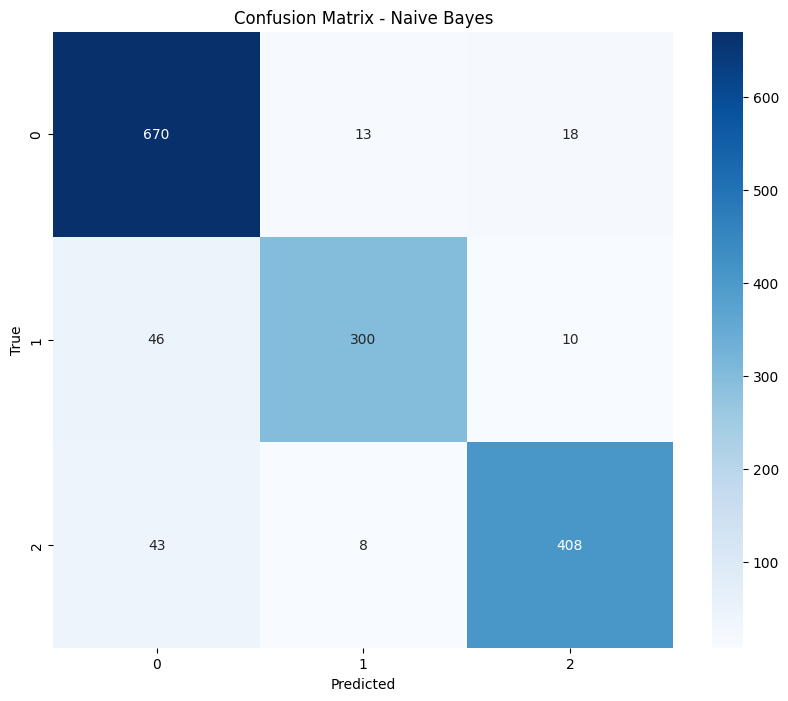

In [ ]:
from sklearn.naive_bayes import MultinomialNB

tfidf_param_grid_nb = {
    'tfidf__max_features': [500, 1000, 1500],
    'tfidf__stop_words': [None, 'english'],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
}

nb_param_grid = {
    'nb__alpha': [0.1, 1, 10],
}

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

param_grid_nb = {**tfidf_param_grid_nb, **nb_param_grid}

grid_search_nb = GridSearchCV(nb_pipeline, param_grid_nb, cv=5, scoring='roc_auc_ovr')
grid_search_nb.fit(X, y)

print("Best parameters - Naive Bayes:")
print(grid_search_nb.best_params_)

y_pred_nb = grid_search_nb.predict(X_test)
print("Classification Report - Naive Bayes:\n")
print(classification_report(y_test, y_pred_nb))
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
y_pred_proba_nb = grid_search_nb.predict_proba(X_test)

roc_auc_nb = roc_auc_score(y_test, y_pred_proba_nb, multi_class="ovr")
print("ROC AUC Score - Naive Bayes:", roc_auc_nb)

ROC AUC Score - Naive Bayes: 0.9872256850691548


### Results Summary

Benchmark Model Performance:
  + ACCY: __0.88__
  + ROC AUC: __0.9717__


Best Logistic Regression Model Performance:
  + ACCY: __0.95__
  + ROC AUC: __0.9951__
  + Vectorization params: {'tfidf__max_features': 1500, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}

  + Model params: {'logreg__C': 10, 'logreg__penalty': 'l2'}


Best Naive Bayes Model Performance:
  + ACCY: __0.91__
  + ROC AUC: __0.9872__
  + Vectorization params: {'tfidf__max_features': 1500, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}
  + Model params: {'nb__alpha': 0.1}






Which model / grid search performs the best? What are its parameters? FYI: we can use the grid search object's `best_estimator_` and `named_steps` properties to access the parameters for the model and the vectorizer, respectively).

Answer: The best-performing model is the Logistic Regression with a ROC AUC of 0.9951, which is higher than the Naive Bayes model's 0.9872 and the benchmark model's 0.9717. Its parameters are {'logreg__C': 10, 'logreg__penalty': 'l2'} for the model and {'tfidf__max_features': 1500, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None} for the vectorization.

How does your best model compare with the initial benchmark from Part I?

Answer: The Logistic Regression model shows a significant improvement over the benchmark, with an increase in accuracy from 0.88 to 0.95 and in ROC AUC from 0.9717 to 0.9951, indicating a more precise classification capability.

What parameter or methodology changes had the greatest impact on improving model performance?

Answer: The greatest impact on model performance came from fine-tuning both the vectorization and the model parameters using grid search optimization. For Logistic Regression, the selection of {'logreg__C': 10, 'logreg__penalty': 'l2'} alongside the TF-IDF vectorization parameters {'tfidf__max_features': 1500, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None} led to a substantial increase in both accuracy and ROC AUC score, indicating a strong model fit.


